<a href="https://www.kaggle.com/code/kriggs/bellabeat-case-study-3-3-ml-modelling?scriptVersionId=142865244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BellaBeat Case Study 3/3 - ML Modelling

In this notebook I'll be creating ML models to predict abnormal heart rate conditions based off the Dataset from Fitbit in the BellaBeat case study.

The inspiration for the ML algorithm is based off the video "Anomaly detection with TensorFlow" by Laurence Moroney.

The very short version of the video is, if you train a good ML model on "normal" data, then there will be huge residuals when predicting on "abnormal" data.

The "normal" data was selected in part 2 of this study.

This Study is split into 3 parts:
- Part 1 - Data exploration and inspiration to the question  
    https://www.kaggle.com/code/kriggs/bellabeat-case-study-1-3-data-exploration

- Part 2 - Feature selection  
    https://www.kaggle.com/code/kriggs/bellabeat-case-study-2-3-feature-selection

- Part 3 - ML Modelling  
    This notebook

## Intro: Imports, data loading and training data visualization

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest

import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 4

RED = '#fe6760'

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = '../output_files/'

df = pd.read_pickle(data_dir + 'reduced_dataset_with_train_data.pickle')
df.head()

,date,Name,Id,time_range,Time,METs,Steps,heart_rate,train
0,04-12,Barbara,7007744171,"(2016-04-12 05:36:00, 2016-04-12 05:37:00]",2016-04-12 05:36:30,10.0,0.0,101.000000,False
1,04-12,Barbara,7007744171,"(2016-04-12 06:03:00, 2016-04-12 06:04:00]",2016-04-12 06:03:05,10.0,0.0,70.000000,False
2,04-12,Barbara,7007744171,"(2016-04-12 06:26:00, 2016-04-12 06:27:00]",2016-04-12 06:26:30,30.0,10.0,97.250000,False
3,04-12,Barbara,7007744171,"(2016-04-12 06:27:00, 2016-04-12 06:28:00]",2016-04-12 06:27:05,36.0,28.0,98.800000,False
4,04-12,Barbara,7007744171,"(2016-04-12 06:28:00, 2016-04-12 06:29:00]",2016-04-12 06:28:05,40.0,45.0,101.888889,False


In [3]:
# A look into the train data

feature_cols = ['METs', 'Steps', 'heart_rate']

df.loc[df['train'] == True, feature_cols]

,METs,Steps,heart_rate
10174,13.0,0.0,76.600000
10175,42.0,30.0,94.400000
10176,32.0,25.0,81.714286
10177,38.0,48.0,80.000000
10178,42.0,39.0,81.571429
...,...,...,...
288533,13.0,0.0,70.300000
288534,12.0,0.0,61.000000
288535,11.0,0.0,55.400000
288536,24.0,5.0,54.000000


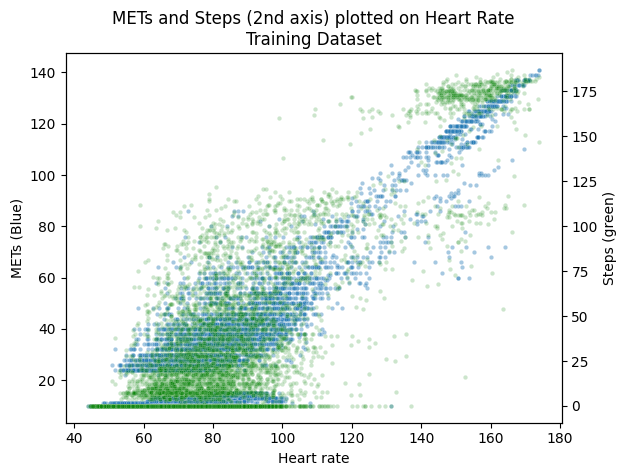

In [4]:
# Plotting the train data

X = df[df['train'] == True][feature_cols]

ax = sns.scatterplot(data=X, x='heart_rate', y='METs', s=10, alpha=0.4)
ax2 = sns.scatterplot(data=X, x='heart_rate', y='Steps', ax=ax.twinx(), color='green', s=10, alpha=0.2);

ax.set(
    title='METs and Steps (2nd axis) plotted on Heart Rate\nTraining Dataset',
    xlabel='Heart rate',
    ylabel='METs (Blue)'
)

ax2.set(
    ylabel='Steps (green)'
);

# 1. Isolation Forest

Isolation forest is an anomaly detection algorithm, where the forest goes all the way to a single leaf, and the shortest paths to isolating a point are considered outliers.

In [5]:
clf = IsolationForest(n_jobs=-1, contamination=0.1).fit(X.to_numpy())
X_with_outliers = X.copy()
X_with_outliers['outliers_iso'] = clf.predict(X.to_numpy())
X_with_outliers['outliers_iso'].value_counts()

outliers_iso
 1    12623
-1     1403
Name: count, dtype: int64

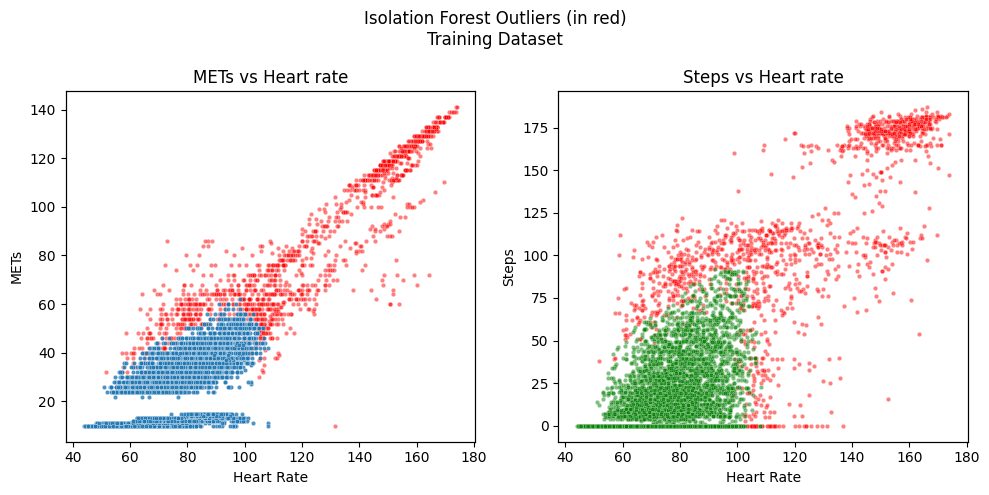

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=False)
axs = axs.flatten()
twinaxs = []

fig.suptitle(
	'Isolation Forest Outliers (in red)\nTraining Dataset'
)

sets_1st_plot = {
	'title':'METs vs Heart rate'
}

sets_2nd_plot = {
	'title':'Steps vs Heart rate'
}

(sns.scatterplot(data=X_with_outliers.query('outliers_iso == -1'), x='heart_rate', y='METs', color='red', s=10, alpha=0.5, ax=axs[0]).set(**sets_1st_plot))
twinaxs.append(sns.scatterplot(data=X_with_outliers.query('outliers_iso == 1'), x='heart_rate', y='METs', s=10, alpha=0.8, ax=axs[0].twinx()))

sns.scatterplot(data=X_with_outliers.query('outliers_iso == -1'), x='heart_rate', y='Steps', color='red', s=10, alpha=0.5, ax=axs[1]).set(**sets_2nd_plot);
twinaxs.append(sns.scatterplot(data=X_with_outliers.query('outliers_iso == 1'), x='heart_rate', y='Steps', s=10, alpha=0.5, ax=axs[1].twinx(), color='green'))

for i_ax, i_twinax in zip(axs, twinaxs):
	ymin = np.min([*i_ax.get_ylim(), *i_twinax.get_ylim()])
	ymax = np.max([*i_ax.get_ylim(), *i_twinax.get_ylim()])

	i_ax.set(
		xlabel='Heart Rate'
	)

	i_twinax.set(
		yticks=[],
		ylabel=''
	)

	for axs in [i_ax, i_twinax]:
		axs.set(
			ylim=[ymin, ymax]
		)

fig.tight_layout()

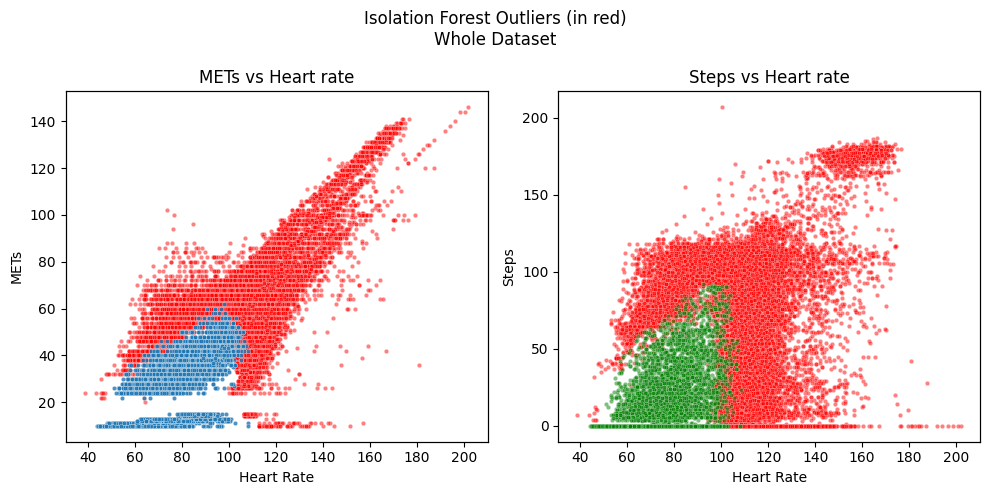

In [7]:
df['outliers_iso'] = clf.predict(df[feature_cols])

fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=False)
axs = axs.flatten()
twinaxs = []

fig.suptitle(
	'Isolation Forest Outliers (in red)\nWhole Dataset'
)

sets_1st_plot = {
	'title':'METs vs Heart rate'
}

sets_2nd_plot = {
	'title':'Steps vs Heart rate'
}

(sns.scatterplot(data=df.query('outliers_iso == -1'), x='heart_rate', y='METs', color='red', s=10, alpha=0.5, ax=axs[0]).set(**sets_1st_plot))
twinaxs.append(sns.scatterplot(data=X_with_outliers.query('outliers_iso == 1'), x='heart_rate', y='METs', s=10, alpha=0.8, ax=axs[0].twinx()))

sns.scatterplot(data=df.query('outliers_iso == -1'), x='heart_rate', y='Steps', color='red', s=10, alpha=0.5, ax=axs[1]).set(**sets_2nd_plot);
twinaxs.append(sns.scatterplot(data=X_with_outliers.query('outliers_iso == 1'), x='heart_rate', y='Steps', s=10, alpha=0.5, ax=axs[1].twinx(), color='green'))

for i_ax, i_twinax in zip(axs, twinaxs):
	ymin = np.min([*i_ax.get_ylim(), *i_twinax.get_ylim()])
	ymax = np.max([*i_ax.get_ylim(), *i_twinax.get_ylim()])

	i_ax.set(
		xlabel='Heart Rate'
	)

	i_twinax.set(
		yticks=[],
		ylabel=''
	)

	for axs in [i_ax, i_twinax]:
		axs.set(
			ylim=[ymin, ymax]
		)

fig.tight_layout()

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Conclusion Isolation Forest </font>
   
<li> Isolation forest does have it uses in the industry, for example fraud detection, unfortunately for this use case it just detected as any high value to be an anomaly
<li> Hyperparameter tunning was performed, but didn't yield much difference.

</div>

# 2. Linear Regression

Here I tested 3 linear regression model, the simple one without any hyperparameters, and Ridge and Lasso with regularization parameters to avoid overfitting.

They were all tested and the one with the lowest R2 score was selected.

In [8]:
y_train = X['heart_rate'].copy()
X_train = X.drop(columns='heart_rate')

In [9]:
def draw_1_1_line(ax:plt.axes) -> None:
	_, xmax, _, ymax = ax.axis()
	axis_limit = [0, min(xmax, ymax)]
	sns.lineplot(x=axis_limit, y=axis_limit, color='r', ax=ax)

Best regressor: LinearRegression()


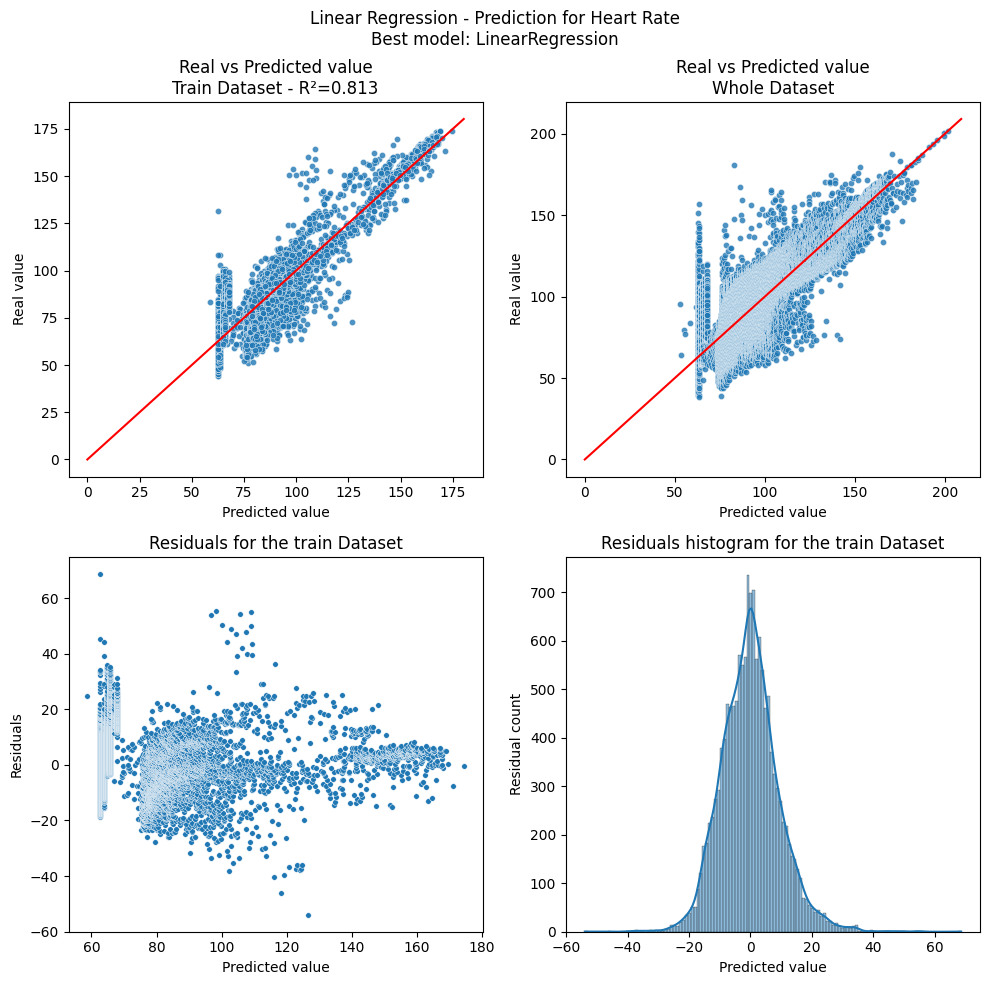

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Class to hold the best linear model
class class_best_regressor:
	score = 0
	model = LinearRegression().fit(X_train, y_train)

	def check_regressor(self, regressor):
		new_score = regressor.score(X_train, y_train)
		if(new_score > self.score):
			self.score = new_score
			self.model = regressor

	def get_name(self) -> str:
		return self.model.__class__.__name__

best_regressor = class_best_regressor()

# Simple linear regression
linreg = LinearRegression().fit(X_train, y_train)

best_regressor.check_regressor(linreg)

# Lasso model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linlasso = Lasso(alpha=alpha, max_iter = 100_000).fit(X_train, y_train)
	best_regressor.check_regressor(linlasso)

# Ridge Model

for alpha in [0.00001, 0.001, 0.005, 0.05, 0.5, 1]:
	linridge = Ridge(alpha=alpha, max_iter = 10000).fit(X_train, y_train)
	best_regressor.check_regressor(linridge)

# Print best linear model

print(f'Best regressor: {best_regressor.model}')

# Plot best model

fig, axs =  plt.subplots(2,2, figsize=(10,10))
fig.suptitle(f'Linear Regression - Prediction for Heart Rate\nBest model: {best_regressor.get_name()}')
axs = iter(axs.reshape(1, -1)[0])

# Plotting of the train dataset
ax = next(axs)
y_hat_train = pd.Series(best_regressor.model.predict(X_train), index=y_train.index).sort_values()
sns.scatterplot(x=y_hat_train, y=y_train, marker= 'o', s=20, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Real vs Predicted value\nTrain Dataset - R²={best_regressor.model.score(X_train, y_train):.3f}'
)

draw_1_1_line(ax)

# Plotting whole dataset
X_whole = df[X_train.columns]
ax = next(axs)
y_hat = pd.Series(best_regressor.model.predict(X_whole), index=X_whole.index).sort_values()
sns.scatterplot(x=y_hat, y=df['heart_rate'].loc[y_hat.index], marker= 'o', s=20, alpha=0.8, ax=ax)
ax.set(ylabel='Real value',
       xlabel='Predicted value',
	   title=f'Real vs Predicted value\nWhole Dataset'
)

draw_1_1_line(ax)

# Plotting of residuals Scatterplot

ax = next(axs)
sorted_y_train = y_train.sort_values()
sorted_x_train = X_train.reindex(sorted_y_train.index)
predicted_values = best_regressor.model.predict(sorted_x_train)
residuals = sorted_y_train - predicted_values
sns.scatterplot(x=predicted_values, y=residuals, ax=ax)
ax.set(ylabel='Residuals',
       xlabel='Predicted value',
	   title=f'Residuals for the train Dataset'
);

# Plotting of residuals Histogram

ax = next(axs)
sns.histplot(data=residuals, ax=ax, kde=True)
ax.set(ylabel='Residual count',
       xlabel='Predicted value',
	   title=f'Residuals histogram for the train Dataset'
);

fig.tight_layout()

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Inference Residuals Linear Regression </font>
   
<li> On the 1st and 2nd graph we see the real value plotted on the y axis against the predicted value from the best model in the X axis, in a perfect model all the points would fall on the red line
<li> The residuals "shape" on the top graphs (train dataset and whole dataset, respectively) show that the train selection was a good representation of the whole dataset
<li> The points that deviate too much from this red line, as in, have greater residuals, will be considered outliers

</div>

For the definition of what we'll consider an outlier, we'll use the rule of 3x the standard deviation from the mean.

In [11]:
def get_outliers(series: pd.Series, by:str='zscore') -> tuple[float, float]:
	"""
    Get the lower and upper bounds of the outliers in a pandas series.

    Parameters:
    -----------
    series : pd.Series
        The pandas series to get the outliers from.
    by : str, optional (default='zscore')
        The method to use for calculating the outliers. Can be 'IQR' or 'zscore'.

    Returns:
    --------
    tuple(float, float)
        A tuple containing the lower and upper bounds of the outliers.
    """
	if by == 'IQR':
		q25 = series.quantile(.25)
		q75 = series.quantile(.75)
		iqr = q75 - q25

		return q25 - (1.5 * iqr), q75 + (1.5 * iqr)

	if by == 'zscore':
		mean, std = series.agg(['mean', 'std'])
		return mean - 3 * std, mean + 3 * std
	
	raise ValueError(f'"by" not found: {by}')

In [12]:
lower_bound, upper_bound = get_outliers(pd.Series(residuals), by='zscore')
df_linear = df.copy()
df_linear['predicted'] = best_regressor.model.predict(df_linear[['METs', 'Steps']])
df_linear['residuals'] = df_linear['heart_rate'] - df_linear['predicted']
df_linear['outliers_lin'] = np.where((df_linear['residuals'] < lower_bound) | (df_linear['residuals'] > upper_bound), True, False)
df_linear.head()

,date,Name,Id,time_range,Time,METs,Steps,heart_rate,train,outliers_iso,predicted,residuals,outliers_lin
0,04-12,Barbara,7007744171,"(2016-04-12 05:36:00, 2016-04-12 05:37:00]",2016-04-12 05:36:30,10.0,0.0,101.000000,False,1,62.683559,38.316441,True
1,04-12,Barbara,7007744171,"(2016-04-12 06:03:00, 2016-04-12 06:04:00]",2016-04-12 06:03:05,10.0,0.0,70.000000,False,1,62.683559,7.316441,False
2,04-12,Barbara,7007744171,"(2016-04-12 06:26:00, 2016-04-12 06:27:00]",2016-04-12 06:26:30,30.0,10.0,97.250000,False,1,81.622196,15.627804,False
3,04-12,Barbara,7007744171,"(2016-04-12 06:27:00, 2016-04-12 06:28:00]",2016-04-12 06:27:05,36.0,28.0,98.800000,False,1,85.035753,13.764247,False
4,04-12,Barbara,7007744171,"(2016-04-12 06:28:00, 2016-04-12 06:29:00]",2016-04-12 06:28:05,40.0,45.0,101.888889,False,1,86.555447,15.333442,False


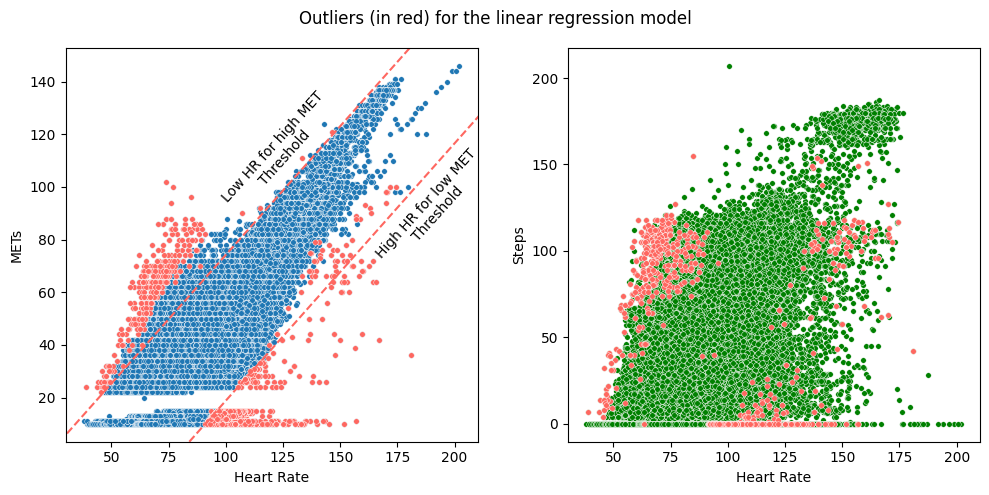

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

fig.suptitle('Outliers (in red) for the linear regression model')

ax = axs[0]
sns.scatterplot(data=df_linear, x='heart_rate', y='METs', ax=ax)
sns.scatterplot(data=df_linear[df_linear['outliers_lin'] == True], x='heart_rate', y='METs', color=RED, ax=ax)

x_lim, y_lim = (ax.get_xlim(), ax.get_ylim())

y_coefs = np.array(ax.get_ylim())
x_coefs = y_coefs * best_regressor.model.coef_[0] + (lower_bound + best_regressor.model.intercept_)
x_coefs2 = y_coefs * best_regressor.model.coef_[0] + (upper_bound + best_regressor.model.intercept_)

sns.lineplot(x=x_coefs, y=y_coefs, ax=ax, color=RED, linestyle='--')
sns.lineplot(x=x_coefs2, y=y_coefs, ax=ax, color=RED, linestyle='--')

text_args = {'rotation':48, 'fontweight':400, 'ha':'center', 'size':10}
ax.text(123,90, 'Low HR for high MET\nThreshold', **text_args)
ax.text(190,69, 'High HR for low MET\nThreshold', **text_args)

ax.set(xlim=x_lim, ylim=y_lim)

ax = axs[1]
sns.scatterplot(data=df_linear, x='heart_rate', y='Steps', ax=ax, color='green')
sns.scatterplot(data=df_linear[df_linear['outliers_lin'] == True], x='heart_rate', y='Steps', color=RED, ax=ax)

for ax in axs:
	ax.set(
		xlabel='Heart Rate'
	)

fig.tight_layout()

In [14]:
pd.DataFrame(best_regressor.model.coef_.reshape(1,2), columns=['Coef for METs', 'Coef for Steps'])

,Coef for METs,Coef for Steps
0,1.022533,-0.151202


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Inference Linear Regression </font>
   
<li> In the above graphs and the coeficients we can see that the linear regression considered an almost perfect linear relationship between HR and METs, this was also corroborated by the correlation variables
<li> The red dashed lines in the graph on the left are the threshold for what the model considers an outlier based solely on METs, the non-outlier points in the "Low HR for high MET" region is explained by the negative relationship from Steps, the same is valid for the outliers inside the non-outlier region

</div>

## Visualizing these outliers during the day

In [15]:
print('Outliers detected in the Linear Regression: ', df_linear['outliers_lin'].sum())
print('Dates with most outliers per user:')
outliers_per_day_user = (df_linear[df_linear['outliers_lin'] == True]
						 .groupby(['date', 'Name'])['Id']
						 .count()
						 .unstack()
						 .reset_index()
						 .melt(id_vars=['date'])
						 .sort_values('value', ascending=False))

outliers_per_day_user.head(10)

Outliers detected in the Linear Regression:  5271
Dates with most outliers per user:


,date,Name,value
70,04-20,Elizabeth,156.0
380,04-20,William,155.0
248,04-12,Patricia,131.0
270,05-04,Patricia,124.0
386,04-26,William,108.0
379,04-19,William,107.0
382,04-22,William,105.0
0,04-12,Barbara,101.0
395,05-05,William,91.0
2,04-14,Barbara,90.0


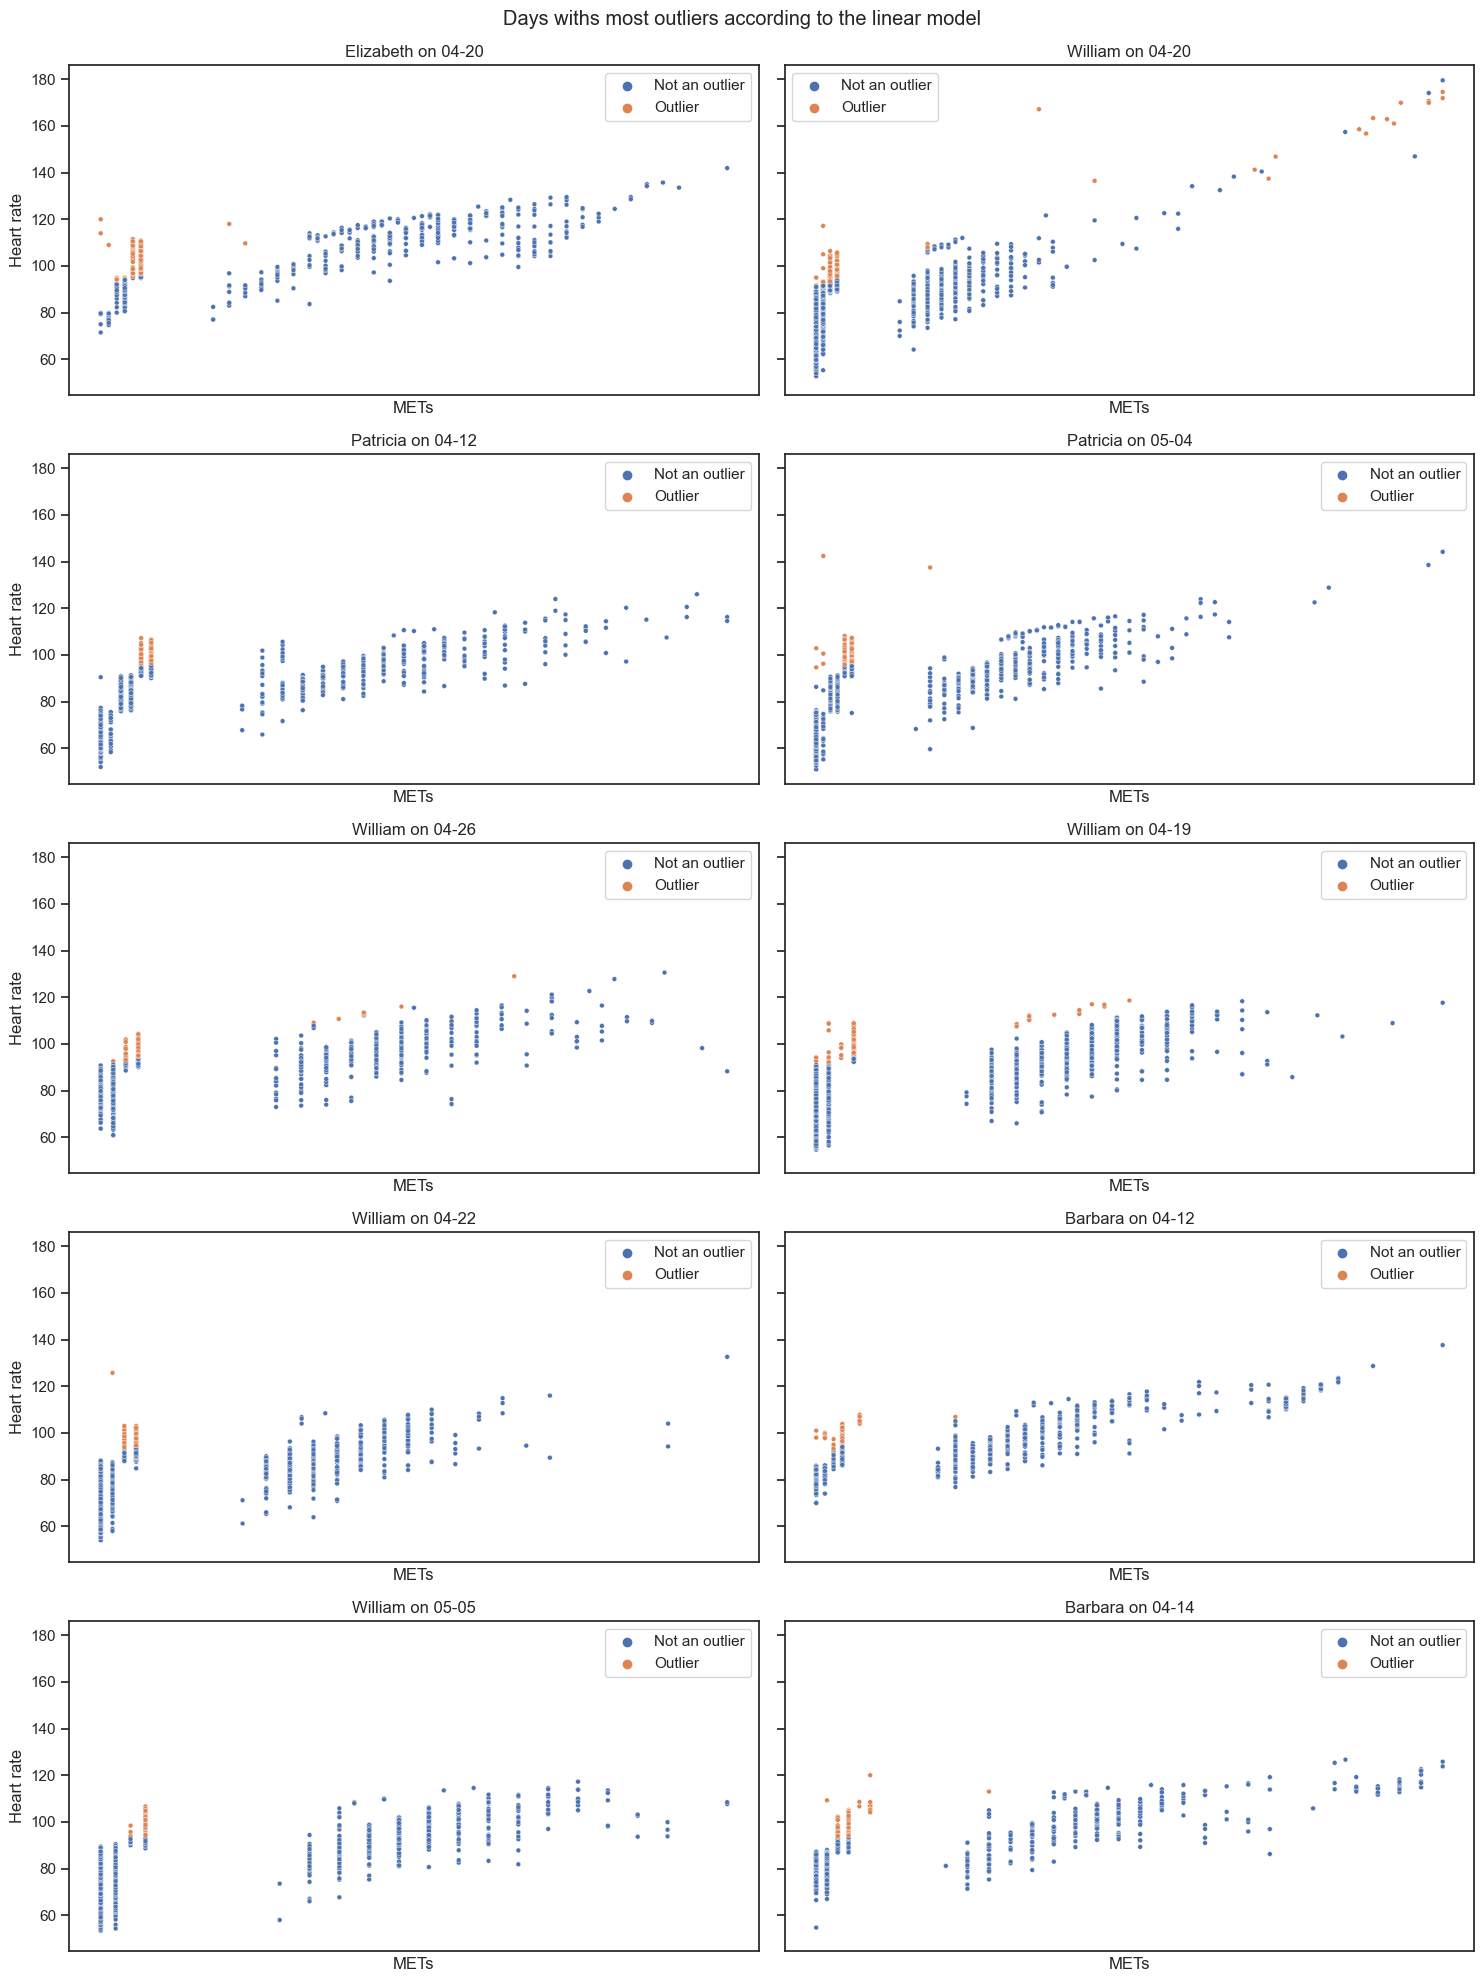

In [16]:
num_cols = 2
num_rows = 5

sns.set_theme(style="ticks")
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,20), sharex=False, sharey=True)
fig.suptitle('Days withs most outliers according to the linear model', y=0.99)
axs = iter(axs.flatten())

for date, name in outliers_per_day_user[['date', 'Name']].head(10).values:
	ax = next(axs)
	mask_date = df_linear['date'] == date
	mask_name = df_linear['Name'] == name
	sns.scatterplot(data=df_linear[mask_date & mask_name], x='METs', y='heart_rate', ax=ax, hue='outliers_lin', s=12)
	ax.set(
		xlabel='METs',
		xticks=[],
		ylabel='Heart rate',
		title=f'{name} on {date}'
	)
	
	h, _ = ax.get_legend_handles_labels()
	ax.legend(
		title='',
		handles=h,
		labels=['Not an outlier', 'Outlier']
	)

fig.tight_layout()

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #72d798; font-size:100%; text-align:left; color: #000000"><font color='#1a3b1c'>

##  Conclusions </font>

In this study I explored and analysed the BellaBeat dataset statiscally and built a model for detecting heart rate anomalies based on measurements from the tracking devices, the feature of abnormal HR could be integrated in the tracking devices OTA without the need for extra costs, improving the features of the devices using only data.
    
In the first part of this study questioned "is it possible to automate the anomaly detection of the HR", and to this question I showed here that with this data and method: maybe.
    
In the last graphs of this study the models did selected a high HR for a low MET, but the model were extremely simple so this is to be considered a proof of concept, here are some suggestions that could improve this model and concept:
    
<li> Access to more user data, during the exploration weight data was very scarce and could not be used, age, sex and many others, which understandably couldn't be shared, could also improve a lot the model
<li> Cross Validation was not performed and would definitely improve the model
<li> Feature engineering, as the exploration showed non-linear relationships
<li> Feature scaling on the models
<li> Test other models when more data is available - I ran TensorFlow but it overfitted very easily, also it was harder to explain graphically as to what's an outlier with boundaries

</div>
